<a href="https://colab.research.google.com/github/DilendraSajini/Dissertation/blob/main/Source_Code_BatchSize_9_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Install the livelossplot library using pip**

In [ ]:
! pip install livelossplot

# **Mount Google Drive to access files**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Import required libraries**

In [ ]:
import tensorflow as tf
from typing import Tuple
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model,Sequential
import os
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization, GaussianNoise, Bidirectional, LSTM
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from livelossplot.tf_keras import PlotLossesCallback
from tensorflow import keras
import os
import glob
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, log_loss,confusion_matrix
import matplotlib.pyplot as plt
import time

# **Paths to saved model files**

In [ ]:
base_model_path = '/content/drive/MyDrive/Colab Notebooks/Dissertation/models/Colab_Source_Code_BatchSize_9_2.h5'
feature_extractor_path = '/content/drive/MyDrive/Colab Notebooks/Dissertation/models/Feature_Extractor_Colab_Source_Code_BatchSize_9_2.h5'
LSTM_classifier_path = '/content/drive/MyDrive/Colab Notebooks/Dissertation/models/Classifier_Colab_Source_Code_BatchSize_9_2.h5'

---
# **Paths to directory containing training, testing, and validation data**


In [ ]:
directory_path_train ="/content/drive/MyDrive/Colab Notebooks/sample/train"
directory_path_test ="/content/drive/MyDrive/Colab Notebooks/sample/test"
directory_path_validation ="/content/drive/MyDrive/Colab Notebooks/sample/validation"

---
# **Define the size of the images**

In [ ]:
SIZE = (224,224)

# **The Image Generator Factory**

In [ ]:
from keras.applications.vgg16 import preprocess_input
class GeneratorFactory:
  def __init__(self, directory_path_train, directory_path_test, directory_path_validation):
      self.directory_path_train = directory_path_train
      self.directory_path_test = directory_path_test
      self.directory_path_validation = directory_path_validation
      self.train_datagen = ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=15,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      width_shift_range=0.1,
      height_shift_range=0.1,
      fill_mode='reflect')
      self.validation_datagen= ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=15,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      width_shift_range=0.1,
      height_shift_range=0.1,
      fill_mode='reflect')
      self.test_datagen= ImageDataGenerator(preprocessing_function=preprocess_input)
  def _get_train_gen(self):
    train_generator = self.train_datagen.flow_from_directory(
    self.directory_path_train,
    target_size = SIZE,
    batch_size = 10,
    shuffle=True,
    class_mode = 'binary')
    return train_generator

  def _get_validation_gen(self):
    validation_generator = self.validation_datagen.flow_from_directory(
    self.directory_path_validation,
    target_size = SIZE,
    batch_size = 10,
    shuffle=True,
    class_mode = 'binary')
    return validation_generator

  def _get_test_gen(self):
    test_datagen= ImageDataGenerator()
    test_generator = self.test_datagen.flow_from_directory(
        self.directory_path_test,
        target_size = SIZE,
        batch_size = 10,
        shuffle=False,
        class_mode = 'binary')
    return test_generator
  def get_generator(self,generator_type):
    if generator_type == 'train':
        return self._get_train_gen()
    if generator_type == 'validation':
        return self._get_validation_gen()
    if generator_type == 'test':
        return self._get_test_gen()


# **The VGG16 Base Model**

In [ ]:
class BaseModel:
    def __init__(self, model):
        self.model = model
        for layer in self.model.layers:
            layer.trainable = False

    def add_classifier_layer(self):
        classifier_model = Sequential()
        classifier_model.add(self.model)
        classifier_model.add(GaussianNoise(0.25))
        classifier_model.add(GlobalAveragePooling2D())
        classifier_model.add(Dense(512, activation='relu'))
        classifier_model.add(BatchNormalization())
        classifier_model.add(Dense(1, activation='sigmoid'))
        self.model = classifier_model

    def compile(self, learning_rate):
        self.model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC'])
    def fit(self, train_generator, steps_per_epoch, epochs, validation_gen, callbacks):
            self.model.fit(
            train_generator,
            steps_per_epoch=steps_per_epoch,
            epochs=epochs,
            validation_data=validation_gen,
            callbacks=callbacks
            )
    def evaluate_by_generator(self, generator):
      self.model.evaluate(generator)
    def evaluate_accuracy(self,images,labels, threshold=0.5):
      model_preds = self.model.predict(images)
      ypred = (model_preds > threshold).astype(int)
      model_acc = accuracy_score(labels, ypred)
      return model_acc
    def evaluate_model(self,images,labels,threshold=0.5):
      model_preds = self.model.predict(images)
      y_pred_labels = (model_preds > threshold).astype(int)
      auc = roc_auc_score(labels, model_preds)
      loss = log_loss(labels, model_preds)
      accuracy, precision, recall, cm = self.calculate_metrics(y_pred_labels, labels)
      return accuracy, auc, loss, precision, recall, cm
    def calculate_metrics(self, y_pred_labels,labels):
      accuracy = accuracy_score(labels, y_pred_labels)
      precision = precision_score(labels, y_pred_labels)
      recall = recall_score(labels, y_pred_labels)
      cm = confusion_matrix(labels, y_pred_labels)
      return accuracy, precision, recall, cm
    def get_predictions(self,images,threshold=0.5):
      model_preds = self.model.predict(images)
      y_pred_labels = (model_preds > threshold).astype(int)
      return y_pred_labels
    def save(self, directory):
      self.model.save(directory)

# **The callback function to be used during model training**

In [ ]:
def get_call_back():
  mp= tf.keras.callbacks.ModelCheckpoint(filepath='mymodel.hdf5',
                                verbose=2, save_best_only=True)
  es= tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.05, patience=20)
  pl= PlotLossesCallback()
  callback=[es,mp,pl]
  return callback

# **Data generators for training, validation, and testing datasets**

In [ ]:
gen_factory = GeneratorFactory(directory_path_train,directory_path_test,directory_path_validation)
train_gen = gen_factory.get_generator('train')
validation_gen = gen_factory.get_generator('validation')
test_gen = gen_factory.get_generator('test')

Found 1800 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
Found 2352 images belonging to 2 classes.


# **Compile the base model**

In [ ]:
base_model_instance = BaseModel(VGG16(weights='imagenet', input_shape=(224, 224, 3), include_top=False))
base_model_instance.model.summary()
base_model_instance.add_classifier_layer()
base_model_instance.model.summary()
base_model_instance.compile(0.001)


58889256/58889256 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

# **The Utility Class**

In [ ]:
class ImageUtil:
    @staticmethod
    def _load_image(filename: str, label: int, IMG_SIZE: Tuple) -> Tuple[tf.Tensor, int]:
        file = tf.io.read_file(filename)
        img = tf.image.decode_png(file, channels=3)
        return img, label

    @classmethod
    def extract_images_labels(cls, directory_path: str, IMG_SIZE: Tuple) -> Tuple[list, list, list]:
        images = []
        labels = []
        file_names = []

        benign_path = os.path.join(directory_path, "benign")
        benign_files = glob.glob(os.path.join(benign_path, "*.png"))
        sorted_benign_files = sorted(benign_files, key=lambda x: int(os.path.splitext(os.path.basename(x))[0].split('_')[1]))
        for img_path in sorted_benign_files:
            label = 0
            img, label = cls._load_image(img_path, label, IMG_SIZE)
            images.append(img)
            labels.append(label)
            file_names.append(img_path)

        malignant_path = os.path.join(directory_path, "malignant")
        malignant_files = glob.glob(os.path.join(malignant_path, "*.png"))
        sorted_malignant_files = sorted(malignant_files, key=lambda x: int(os.path.splitext(os.path.basename(x))[0].split('_')[1]))
        for img_path in sorted_malignant_files:
            label = 1
            img, label = cls._load_image(img_path, label, IMG_SIZE)
            images.append(img)
            labels.append(label)
            file_names.append(img_path)

        return images, labels, file_names

    @staticmethod
    def select_sequence_labels(labels, timesteps):
        selected_labels = []
        for i in range(0, len(labels), timesteps):
            selected_labels.append(labels[i])
        return np.array(selected_labels)
    @staticmethod
    def select_sequence_labels_with_majority(labels, threshold=0.5, timesteps=6):
        selected_labels = []
        for i in range(0, len(labels), timesteps):
            batch_labels = labels[i:i+timesteps]
            majority_label = int(np.mean(batch_labels) >= threshold)
            selected_labels.append(majority_label)
        return np.array(selected_labels)
    @staticmethod
    def print_execution_time(start_time, end_time):
       execution_time = end_time - start_time
       print("Execution time:", execution_time, "seconds")
    @staticmethod
    def get_preprocessed_images(images:list):
      preprocessed_patches = []
      for image in images:
          preprocessed_patches.append(preprocess_input(image))
      return np.array(preprocessed_patches)
    def custom_preprocessing(image):
      normalized_image = image / 255.0  #  Normalize to [0, 1] range
      return normalized_image

# **Fit the base model**

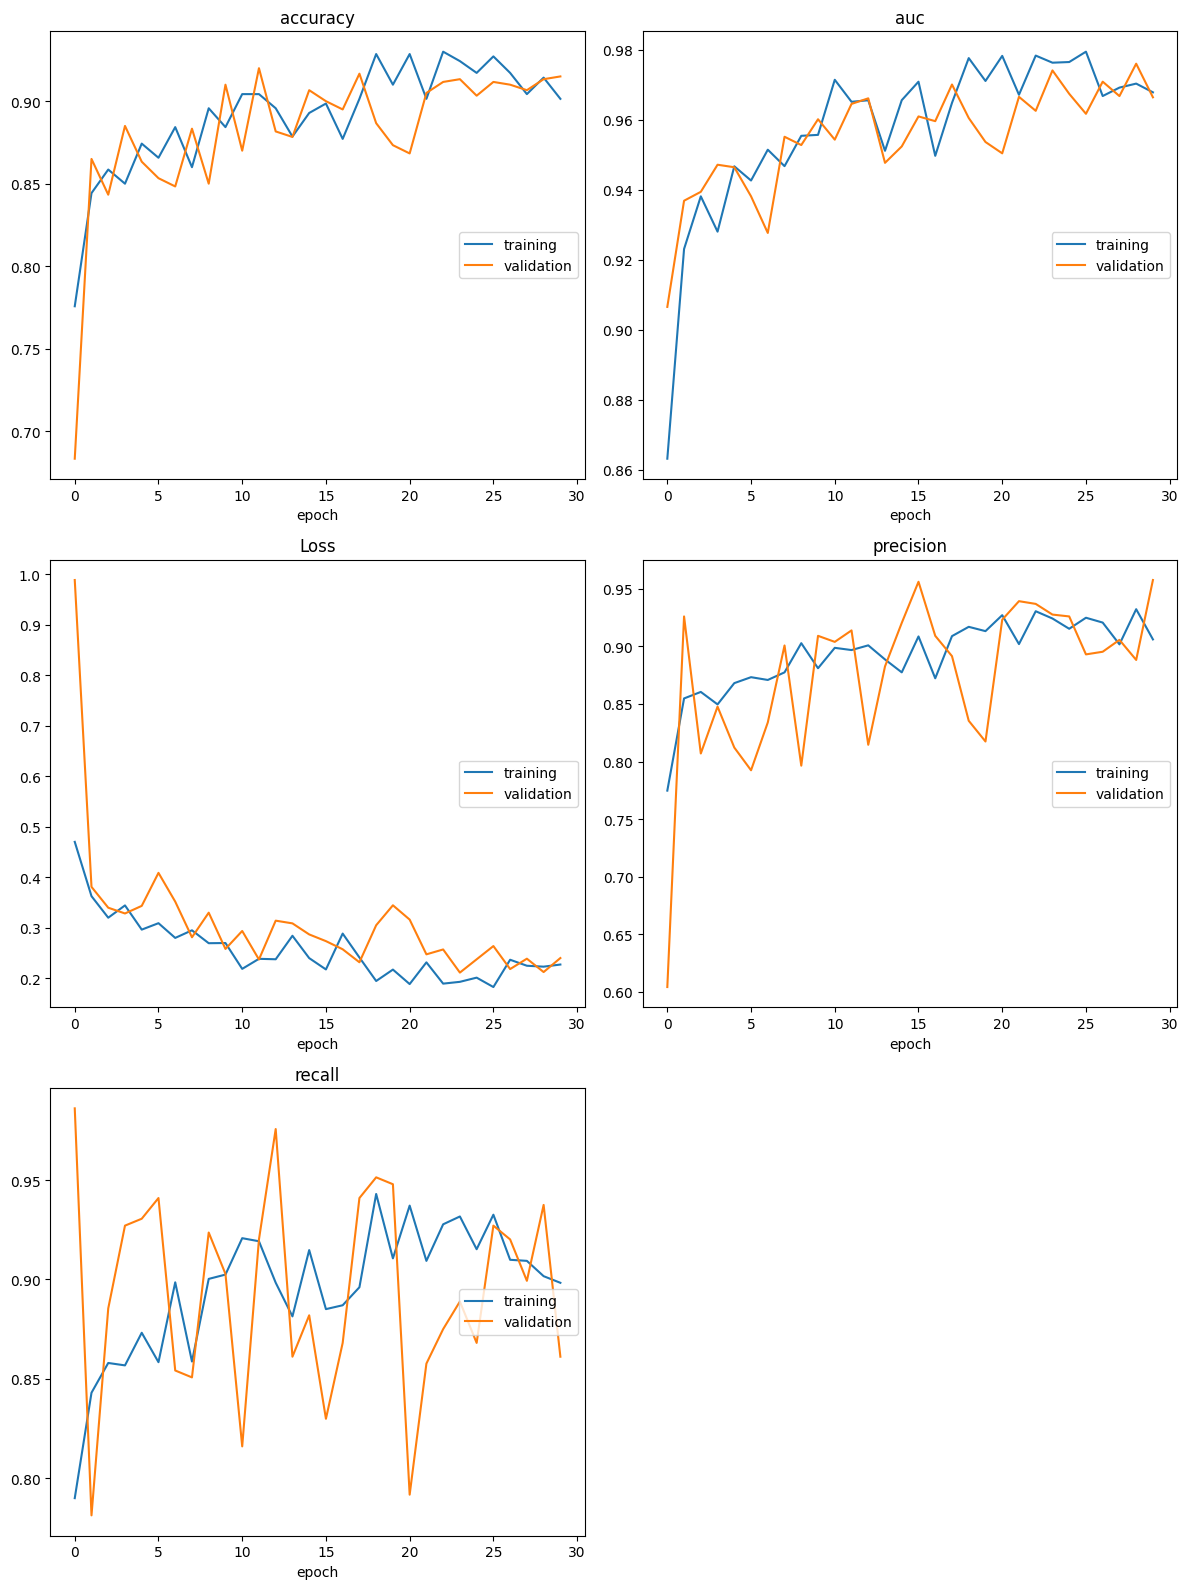

accuracy
	training         	 (min:    0.776, max:    0.930, cur:    0.901)
	validation       	 (min:    0.683, max:    0.920, cur:    0.915)
auc
	training         	 (min:    0.863, max:    0.979, cur:    0.968)
	validation       	 (min:    0.906, max:    0.976, cur:    0.966)
Loss
	training         	 (min:    0.182, max:    0.470, cur:    0.227)
	validation       	 (min:    0.211, max:    0.988, cur:    0.240)
precision
	training         	 (min:    0.775, max:    0.932, cur:    0.906)
	validation       	 (min:    0.604, max:    0.958, cur:    0.958)
recall
	training         	 (min:    0.790, max:    0.943, cur:    0.898)
	validation       	 (min:    0.781, max:    0.986, cur:    0.861)
70/70 [==============================] - 24s 343ms/step - loss: 0.2270 - accuracy: 0.9014 - precision: 0.9060 - recall: 0.8983 - auc: 0.9678 - val_loss: 0.2398 - val_accuracy: 0.9150 - val_precision: 0.9575 - val_recall: 0.8611 - val_auc: 0.9664
Execution time: -2238.2392616271973 seconds


In [ ]:
start_time = time.time()
steps_per_epoch = 70
epochs = 200
trained_model = base_model_instance.fit(train_gen, steps_per_epoch, epochs, validation_gen, get_call_back())
end_time = time.time()
ImageUtil.print_execution_time(end_time, start_time)


# **Model Evalution using generators**

In [ ]:
base_model_instance.evaluate_by_generator(train_gen)

450/450 [==============================] - 36s 80ms/step - loss: 0.4149 - accuracy: 0.8233 - precision: 0.8519 - recall: 0.7884 - auc: 0.8959


In [ ]:
base_model_instance.evaluate_by_generator(validation_gen)

150/150 [==============================] - 13s 85ms/step - loss: 0.3013 - accuracy: 0.8800 - precision: 0.8776 - recall: 0.8715 - auc: 0.9456


# **Model Evalution using test data**

In [ ]:
test_images, test_labels, file_names = ImageUtil.extract_images_labels(directory_path_test, SIZE)
threshold = 0.5
accuracy, auc, loss, precision, recall, cm = base_model_instance.evaluate_model(np.array(test_images), test_labels, threshold)

print("Accuracy:", accuracy * 100)
print("AUC:", auc * 100)
print("Loss:", loss * 100)
print("Precision:", precision * 100)
print("Recall:", recall * 100)
print("Confusion Matrix:\n", cm)

74/74 [==============================] - 16s 155ms/step
Accuracy: 79.67687074829932
AUC: 86.02057934545245
Loss: 59.52412428526939
Precision: 80.94812164579606
Recall: 77.35042735042735
Confusion Matrix:
 [[969 213]
 [265 905]]


# **Model Evalution using test data**

In [ ]:
threshold = 0.5
timesteps = 6
selected_labels = base_model_instance.get_predictions(np.array(test_images), threshold)
majority_voting=ImageUtil.select_sequence_labels_with_majority(selected_labels,threshold,timesteps)
actual =ImageUtil.select_sequence_labels(test_labels,timesteps)
accuracy, precision, recall, cm = base_model_instance.calculate_metrics(majority_voting,ImageUtil.select_sequence_labels(test_labels,timesteps))

print("Accuracy:", accuracy * 100)
print("Precision:", precision * 100)
print("Recall:", recall * 100)
print("Confusion Matrix:\n", cm)

74/74 [==============================] - 9s 120ms/step
Accuracy: 88.77551020408163
Precision: 87.56218905472637
Recall: 90.25641025641026
Confusion Matrix:
 [[172  25]
 [ 19 176]]


# **Plot Image subset**

In [ ]:
for i, (label, image, file_name) in enumerate(zip(test_labels, test_images, file_names), 1):
   if i > 2000:
        plt.imshow(np.array(image).astype(np.uint8))
        plt.axis('off')
        plt.show()
        print("Label:", label)

# **Save Base model**

In [ ]:
base_model_instance.save(base_model_path) #should save the model

# **LSTM Classifier**

In [ ]:
class LSTM_Classifier:
    def __init__(self):
        timesteps = 6 # number of patch sequence images extractes from full image
        data_dim = 512 # equals number of fetures out puts from feature extractor
        self.classifier = Sequential()
        self.classifier.add(Bidirectional(LSTM(500), input_shape=(timesteps, data_dim)))  # Add LSTM layer with 64 units and specify the input shape
        self.classifier.add(BatchNormalization())
        self.classifier.add(Dense(1, activation='sigmoid'))

    def compile(self, learning_rate):
        self.classifier.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC'])
    def fit(self, train_features, train_labels, epochs, validation_features, validation_labels, callbacks):
        model = self.classifier.fit(
        train_features,
        train_labels,
        epochs=epochs,
        validation_data=(validation_features,validation_labels),
        callbacks=callbacks)
    def evaluate_accuracy(self,feature_vector,labels,threshold=0.5):
      model_preds = self.classifier.predict(feature_vector)
      ypred = (model_preds > threshold).astype(int)
      model_acc = accuracy_score(labels, ypred)
      return model_acc
    def evaluate_model(self,feature_vector,labels,threshold=0.5):
      model_preds = self.classifier.predict(feature_vector)
      y_pred_labels = (model_preds > threshold).astype(int)
      accuracy = accuracy_score(labels, y_pred_labels)
      auc = roc_auc_score(labels, model_preds)
      loss = log_loss(labels, model_preds)
      precision = precision_score(labels, y_pred_labels)
      recall = recall_score(labels, y_pred_labels)
      cm = confusion_matrix(labels, y_pred_labels)
      return accuracy, auc, loss, precision, recall, cm
    def save(self, directory):
      self.classifier.save(directory)

# **Feature Extractor**

In [ ]:
class Feature_Extractor:
     def __init__(self, base_model):
        self.feature_extractor = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)
     def compile(self, learning_rate):
        self.feature_extractor.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC'])
     def predict_features(self, images):
        return self.feature_extractor.predict(images)
     def evaluate_accuracy(self,images,labels, threshold=0.5):
        model_preds = self.feature_extractor.predict(images)
        ypred = (model_preds > threshold).astype(int)
        labels = ImageUtil.select_sequence_labels(labels)
        model_acc = accuracy_score(labels, ypred)
        return model_acc
     def save(self, directory):
        self.feature_extractor.save(directory)

# **Compile the feature extractor**

In [ ]:
#feature_extractor = Feature_Extractor(keras.models.load_model(base_model_path))
feature_extractor = Feature_Extractor(base_model_instance.model)
feature_extractor.feature_extractor.summary()
feature_extractor.compile(0.001)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16_input (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 gaussian_noise (GaussianNoi  (None, 7, 7, 512)        0         
 se)                                                             
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048

# **Save feature extractor**

In [ ]:
feature_extractor.save(feature_extractor_path)

# **Extract fetures from training,validation and testing data**

In [ ]:
train_images, train_labels,train_file_names = ImageUtil.extract_images_labels(directory_path_train, SIZE)
validation_images, validation_labels,validation_file_names = ImageUtil.extract_images_labels(directory_path_validation, SIZE)
test_images, test_labels, file_names = ImageUtil.extract_images_labels(directory_path_test, SIZE)

start_time = time.time()
train_features = feature_extractor.predict_features(np.array(train_images, dtype=float))
validation_features = feature_extractor.predict_features(np.array(validation_images))
test_features = feature_extractor.predict_features(np.array(test_images))
end_time = time.time()
ImageUtil.print_execution_time(end_time, start_time)



74/74 [==============================] - 9s 121ms/step
Execution time: -35.242331743240356 seconds


# **Test data prediction time**

In [ ]:
start_time = time.time()
test_features_1 = feature_extractor.predict_features(np.array(test_images))
end_time = time.time()

74/74 [==============================] - 9s 119ms/step


# **Compile feature classifier**

In [ ]:
feature_classifier = LSTM_Classifier()
feature_classifier.classifier.summary()
feature_classifier.compile(0.0001)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_5 (Bidirectio  (None, 1000)             4052000   
 nal)                                                            
                                                                 
 batch_normalization_6 (Batc  (None, 1000)             4000      
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 1)                 1001      
                                                                 
Total params: 4,057,001
Trainable params: 4,055,001
Non-trainable params: 2,000
_________________________________________________________________


# **Save feature**

In [ ]:
#np.save('/content/drive/MyDrive/Colab Notebooks/Dissertation/models/patch_train_features_preprocesse.npy', train_features)
#np.save('/content/drive/MyDrive/Colab Notebooks/Dissertation/models/patch_validation_features_preprocesse.npy', validation_features)
#np.save('/content/drive/MyDrive/Colab Notebooks/Dissertation/models/patch_test_features_preprocesse.npy', test_features)

# **Fit classifier**

In [ ]:
def get_call_back_class():
  mp= tf.keras.callbacks.ModelCheckpoint(filepath='mymodel.class.hdf5',
                                verbose=2, save_best_only=True)
  es= tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.05, patience=10)
  pl= PlotLossesCallback()
  callback=[es,mp,pl]
  return callback

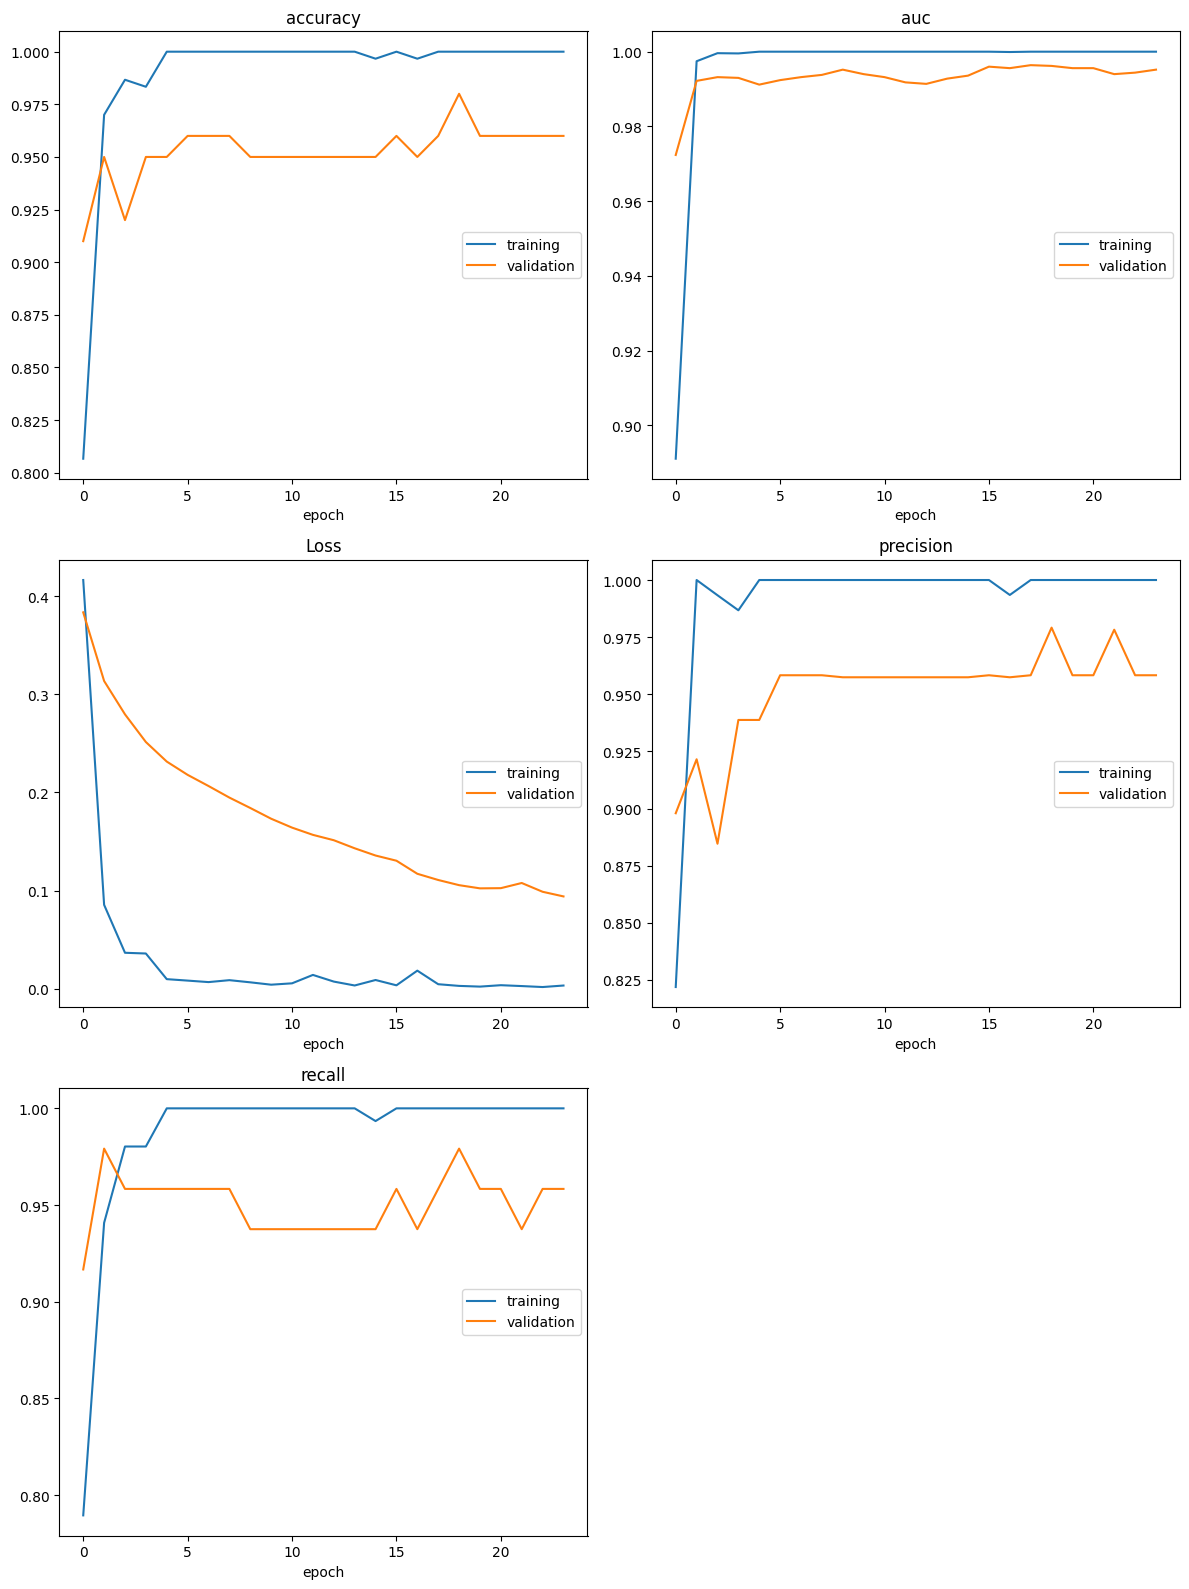

accuracy
	training         	 (min:    0.807, max:    1.000, cur:    1.000)
	validation       	 (min:    0.910, max:    0.980, cur:    0.960)
auc
	training         	 (min:    0.891, max:    1.000, cur:    1.000)
	validation       	 (min:    0.972, max:    0.996, cur:    0.995)
Loss
	training         	 (min:    0.002, max:    0.417, cur:    0.003)
	validation       	 (min:    0.094, max:    0.384, cur:    0.094)
precision
	training         	 (min:    0.822, max:    1.000, cur:    1.000)
	validation       	 (min:    0.885, max:    0.979, cur:    0.958)
recall
	training         	 (min:    0.789, max:    1.000, cur:    1.000)
	validation       	 (min:    0.917, max:    0.979, cur:    0.958)
10/10 [==============================] - 1s 143ms/step - loss: 0.0033 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.0941 - val_accuracy: 0.9600 - val_precision: 0.9583 - val_recall: 0.9583 - val_auc: 0.9952
Execution time: -42.17596387863159 seconds


In [ ]:
timesteps = 6 # number of patch sequence images extractes from full image
train_features_reshaped = train_features.reshape(-1, timesteps, 512)
validation_features_reshaped = validation_features.reshape(-1, timesteps, 512)
test_features_reshaped = test_features.reshape(-1, timesteps, 512)

train_labels_reshaped = ImageUtil.select_sequence_labels(train_labels, timesteps)
validation_labels_reshaped = ImageUtil.select_sequence_labels(validation_labels, timesteps)
test_labels_reshaped = ImageUtil.select_sequence_labels(test_labels, timesteps)

epochs =30
start_time = time.time()
feature_classifier.fit(train_features_reshaped, train_labels_reshaped, epochs, validation_features_reshaped, validation_labels_reshaped, get_call_back_class())
end_time = time.time()
ImageUtil.print_execution_time(end_time, start_time)

# **Evaluate classifier**

In [ ]:
threshold = 0.5
accuracy, auc, loss, precision, recall, cm = feature_classifier.evaluate_model(test_features_reshaped, test_labels_reshaped, threshold)

# Print the evaluation metrics
print("Accuracy:", accuracy * 100)
print("AUC:", auc * 100)
print("Loss:", loss * 100)
print("Precision:", precision * 100)
print("Recall:", recall * 100)
print("Confusion Matrix:\n", cm)

13/13 [==============================] - 1s 3ms/step
Accuracy: 89.79591836734694
AUC: 96.56904854874398
Loss: 24.678524472306915
Precision: 88.17733990147784
Recall: 91.7948717948718
Confusion Matrix:
 [[173  24]
 [ 16 179]]


In [ ]:
threshold = 0.4
accuracy, auc, loss, precision, recall, cm = feature_classifier.evaluate_model(test_features_reshaped, test_labels_reshaped, threshold)

# Print the evaluation metrics
print("Accuracy:", accuracy * 100)
print("AUC:", auc * 100)
print("Loss:", loss * 100)
print("Precision:", precision * 100)
print("Recall:", recall * 100)
print("Confusion Matrix:\n", cm)

13/13 [==============================] - 0s 3ms/step
Accuracy: 89.28571428571429
AUC: 96.56904854874398
Loss: 24.678524472306915
Precision: 86.25592417061611
Recall: 93.33333333333333
Confusion Matrix:
 [[168  29]
 [ 13 182]]


# **Save feature classifier**

In [ ]:
feature_classifier.save(LSTM_classifier_path)

# **Load saved features**

In [ ]:
timesteps = 6
file_path = '/content/drive/MyDrive/Colab Notebooks/Dissertation/models/patch_test_features.npy'
test_features = np.load(file_path)
test_features_reshaped = test_features.reshape(-1, timesteps, 512)
